# Final Notebook 001

## Import

In [10]:
import sentisignal
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import numpy as np 
import pylab as P 
import ast
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import scipy.stats as s
import statsmodels.api as sm
import pprint

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from datetime import datetime
from yahoo_finance import Share
from pandas_datareader import data, wb
from statsmodels.graphics.api import qqplot
from operator import itemgetter
from decimal import *

## Configuration

In [11]:
data_primary_path = '../../data/csv/stocktwits_twitter_withretweets_daily.csv'
data_symbology_path = '../../data/csv/symbology.csv'
data_pickles_path = '../../data/pickles/'
data_nasdaq_company_list_path = '../../data/nasdaq/companylist.csv'
start_date = '2012-01-01'
end_date = '2012-01-03'

## Data Acquisition

### Use NASDAQ data to get top 100 companies by MarketCap

In [31]:
data_nasdaq_company_list = pd.read_csv(data_nasdaq_company_list_path)
data_nasdaq_top_100_mkt_cap = data_nasdaq_company_list.head(100)
data_nasdaq_top_100_mkt_cap_symbols = data_nasdaq_top_100_mkt_cap['Symbol'].unique()

### Calculate breakdown per sector (using PsychSignal symbology)

In [68]:
data_nasdaq_top_100_mkt_cap_symbology = pd.merge(data_nasdaq_top_100_mkt_cap, data_symbology, left_on='Symbol', right_on='symbol', how = "left")
# data_nasdaq_top_100_mkt_cap_symbology.info()
data_nasdaq_top_100_mkt_cap_symbology_sector_size = data_nasdaq_top_100_mkt_cap_symbology.groupby(['sector']).size()
print data_nasdaq_top_100_mkt_cap_symbology_sector_size

sector
Consumer Goods       4
Financial            7
Healthcare          13
Industrial Goods     1
Services            25
Technology          30
dtype: int64


(-1.0128662320463357, 1.0, -1.0193658825849057, 1.0141629122482432)

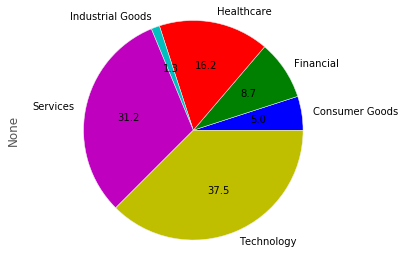

In [67]:
data_nasdaq_top_100_mkt_cap_symbology_sector_size.plot(kind='pie', autopct='%.1f')
plt.axis('equal')
# plt.title('NASAQ Top 100 (by MarketCap) by Sector')

### Calculate and graph yearly mean of average monthly messages

In [75]:
sum_avg_cols = [col for col in data_nasdaq_top_100_mkt_cap_symbology.columns if ('all_scanned_20' in col and 'avg_monthly' in col)]
data_nasdaq_top_100_mkt_cap_symbology['mean_avg_monthly'] = data_nasdaq_top_100_mkt_cap_symbology[sum_avg_cols].sum(axis=1)/len(sum_avg_cols)

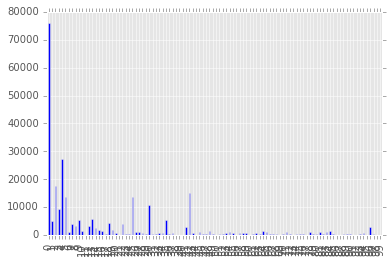

In [76]:
data_nasdaq_top_100_mkt_cap_symbology['mean_avg_monthly'].plot(kind='bar')

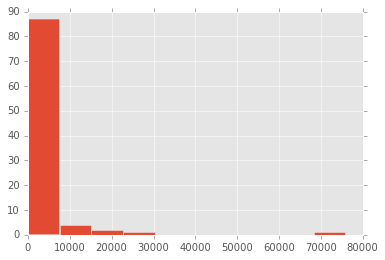

In [91]:
data_nasdaq_top_100_mkt_cap_symbology.hist(column=['mean_avg_monthly'])
plt.title('')

### Correlation matrix

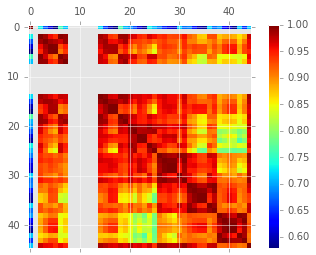

In [100]:
fig = plt.figure()
data_nasdaq_top_100_mkt_cap_symbology_corr = data_nasdaq_top_100_mkt_cap_symbology.corr()
# plt.matshow(data_nasdaq_top_100_mkt_cap_symbology_corr)
# plt.colorbar(data_nasdaq_top_100_mkt_cap_symbology_corr)

labels = data_nasdaq_top_100_mkt_cap_symbology_corr.columns
ax = fig.add_subplot(111)
cax = ax.matshow(data_nasdaq_top_100_mkt_cap_symbology_corr, interpolation='nearest')
fig.colorbar(cax)

# ax.set_xticklabels(['']+labels)
# ax.set_yticklabels(['']+labels)

### MarketCap and mean_avg_monthly regression

5.99528404042e-08 -693.794477431


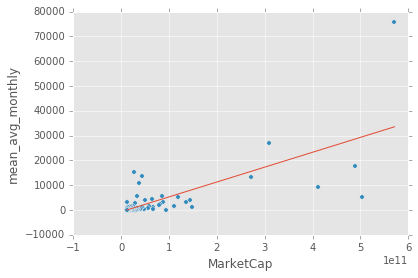

In [115]:
data_nasdaq_top_100_mkt_cap_symbology.plot(kind='scatter', x='MarketCap', y='mean_avg_monthly')
x = data_nasdaq_top_100_mkt_cap_symbology['MarketCap']
y = data_nasdaq_top_100_mkt_cap_symbology['mean_avg_monthly']
idx = np.isfinite(x) & np.isfinite(y)
m, b = np.polyfit(x[idx], y[idx], 1)
plt.plot(x, m*x + b, '-')

### Subsample sentiment data (Daily Stocktwits and Twitter)

In [34]:
data_nasdaq_top_100_sentiment = sentisignal.subsample_data(data_primary_path, data_symbology_path, data_pickles_path, start_date, end_date, 'SYMBOL', data_nasdaq_top_100_mkt_cap_symbols, False)

Subsampling data from csv


In [36]:
data_nasdaq_top_100_sentiment.head()

,SOURCE,SYMBOL,TIMESTAMP_UTC,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES,EXCHANGE,SECTOR,INDUSTRY,TITLE,DATE
20654,stocktwits+twitter_withretweets,AAPL,2012-01-02T05:00:00Z,1.73,1.27,0.46,31,9,3.44,425,NASDAQ,Technology,Personal Computers,Apple Inc.,2012-01-02
105417,stocktwits+twitter_withretweets,ADBE,2012-01-02T05:00:00Z,1.96,2.11,-0.15,1,1,1.00,2,NASDAQ,Technology,Application Software,Adobe Systems Inc.,2012-01-02
125056,stocktwits+twitter_withretweets,ADSK,2012-01-02T05:00:00Z,1.96,0.00,1.96,1,0,0.00,1,NASDAQ,Technology,Technical & System Software,"Autodesk, Inc.",2012-01-02
287963,stocktwits+twitter_withretweets,ALXN,2012-01-02T05:00:00Z,2.18,0.00,2.18,4,0,0.00,17,NASDAQ,Healthcare,Biotechnology,"Alexion Pharmaceuticals, Inc.",2012-01-02
293680,stocktwits+twitter_withretweets,AMAT,2012-01-02T05:00:00Z,0.00,0.00,0.00,0,0,0.00,1,NASDAQ,Technology,Semiconductor Equipment & Materials,Applied Materials Inc.,2012-01-02
